# Project 2

## Molecular Data

The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms.


Analysis will include:
1. Visualization
2. Representation
3. Ridge Regression
4.
5.

In [75]:
%matplotlib inline
import scipy
from scipy import io # this import fixed the issue 
import numpy as np
import torch
import torchvision,torchvision.transforms
import sqlite3
import matplotlib
from matplotlib import pyplot as plt

data = scipy.io.loadmat('qm7.mat')

 The 3d coordinates of each atom in each molecule are available in the variable R. It is an array of size 7165×23×3
containing for each molecule and atom a triplet representing the 3d coordinates.

In [76]:
data['R'][0,0,:] # eg coordinates of first atom in first molecule

array([ 1.886438  , -0.00464873, -0.00823921], dtype=float32)

The variable Z is an array
of size 7165×23 which gives for each molecule and atom of the molecule the corresponding atomic number.
An atomic number of 1 corresponds to a hydrogen atom (H), the number 6 corresponds to carbon (C), the
numbers 7 and 8 to nitrogen (N) and oxygen (O) respectively, and finally, the number 16 corresponds to
sulfur (S). If the number is zero, then it indicates that there is no atom at this index, and the corresponding
3d coordinate should therefore be ignored.

In [77]:
data['Z'][0,0] # first atom of first molecule is carbon

6.0

 This allows for representing in the same array molecules of
different sizes. In addition to these geometrical features of the molecule, the dataset also provides for
each molecule its atomization energy (computed via quantum-chemical simulation). These atomization
energy values are stored in the variable T, an array of size 7165.

In [78]:
data['T'][0] # atomization energy values of first molecule

array([ -417.96,  -712.42,  -564.21, ..., -1662.1 , -1782.01, -1919.  ],
      dtype=float32)

We want to be able to visualize the molecules. For this we are utilizing 3D plotting in Matplotlib. The values for the covalent radii of the atoms is taken from wikipedia, however this isn't an exact science anyways, since we need to add a slight increase to all of them because otherwise the atoms barely aren't close enough.

In [79]:
cov_radii = { # covalent radii in pm
    1.:31.,
    6.:77.2, # this radius might be the wrong one because carbon has more than one covalent radius
    7.:71.,
    8.:66.,
    16.:105.,
}
kindness = 1 # (in pm) additional offset to be added to all radii to make sure they connect

# conversion to atomic units (Bohr radius) and apply kindness
for (k, v) in cov_radii.items():
    cov_radii[k] = (v + kindness) / 52.9

# helper function
def bond(i:int, j:int, coords, ans) -> bool:
    """
    Returns True if and only if the atoms should bond given their atomic numbers and coordinates.
    """
    # if the distance between two atoms is less than the sum
    # of their covalent radii they are considered bonded
    r = cov_radii[ans[i]] + cov_radii[ans[j]]
    dist = coords[i] - coords[j]
    return  np.dot(dist, dist) < r*r #dist^2 < r^2

# visualization
def visualize(ax, molecule_index:int, data=data):
    """
    Creates an image of the molecule at a give index on the given 3DAxis object.
    """

    atoms_present = data['Z'][molecule_index] != 0
    coords = data['R'][molecule_index][atoms_present] # atom coordinates
    ans = data['Z'][molecule_index][atoms_present] # atomic nrs

    # draw atoms
    for (name, nr, m) in [("H", 1, 'o'), ("C", 6, 's'), ("N", 7, 'd'), ("O", 8, '*'), ("S", 16, "^")]:
        elem = coords[ans==nr]
        ax.scatter(elem[:,0], elem[:,1], elem[:,2], s=50, marker=m, label=name)

    # draw lines between atoms that are close enough
    for i in range(len(coords)): # compare all combinations of atoms
        for j in range(i+1, len(coords)):
            if(bond(i, j, coords, ans)):
                # connect with a line
                ax.plot([coords[i][0], coords[j][0]],
                        [coords[i][1], coords[j][1]],
                        zs=[coords[i][2], coords[j][2]],
                        color='y'
                        )
    

In [80]:
from collections.abc import Iterable
from itertools import cycle

def quickly_show_mol(i:int):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    visualize(ax, i)
    ax.legend()
    plt.show()

def show_mols(indices:Iterable, columns:int=3, size=3):
    # size is side length in inches of each square subplot
    """
    Creates and shows a matplotlib graphic containing all molecules specefied via 
    their indices where they are stored in 'data'. The indices can be provided
    as any sort of iterable collection of integers, such as [5,66, 800] or range(...)
    """
    
    # determine the required amount of rows
    rows = int(np.ceil(len(indices) / columns))

    # create the figure
    fig = plt.figure()
    fig.get_axes
    fig.set_size_inches(size*columns, size*rows)
    
    # iteratively fill in all the subplots 
    for (ax_i, i) in enumerate(indices, start=1):
        ax = fig.add_subplot(rows, columns, ax_i, projection='3d')
        
        visualize(ax, i) # this will only draw on the given axis
    
    # show graphic
    plt.show()

Example usage of visualization functions:

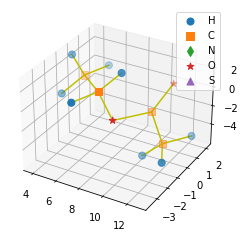

In [81]:
# Example usage of visualize.
quickly_show_mol(800) # molecule at index 800

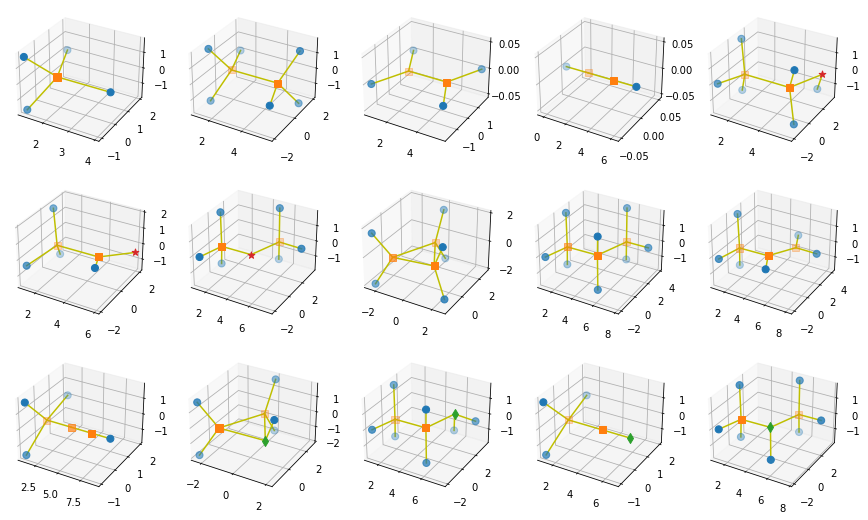

In [85]:
show_mols(range(15), columns=5, size=3) 